### Import Libraries

In [1]:
from wrapper_functions_CAR import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.11.0. Expected: 2.7.0
TensorFlow Probability version: 0.19.0. Expected: 0.15.0


### Create the fake data



In [2]:
#training2010 = pd.read_csv('../data/merged_wp_census_data_280922.csv')
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
#models = ['acs', 'pep', 'worldpop']
models = ['acs', 'pep']

In [10]:
def simulate_data(data, adjacency,pivot = -1, sim_numbers = False, one_model = False, models = ['acs', 'pep', 'worldpop']):
    """Simulated data for the CAR model. 
    
    Args:
        data: The input data file.
        adjacency: the adjacency matrix for the data.
        pivot: The column to be used as the pivot for the softmax ensemble weights. -1 indicates no pivot.
        sim_numbers: whether to simulate data values for the models. If false, the true values are used.
        one_model: whether to only have one model determine the output. Worldpop is the default if this is chosen.
    """
    if sim_numbers:
        data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
        data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
        data['worldpop'] = np.random.normal(120.0, 10.0, data.shape[0])
    
    if one_model:
        data['census'] = np.random.poisson(data['worldpop'].to_numpy())
        
        return _, _, data
    else:
        tau2 = 1
        rho = 0.3
        print('fixing tau2 and rho')
        nchain = 1
        
        Q = (1/tau2)*(np.diag(adjacency.sum(axis=1)) - rho*adjacency)
        Q = tf.constant(Q, dtype = tf.float32)

        if(pivot == -1):
            phi_true = tf.constant(np.array([mv_normal_sample(precision_matrix = Q, 
                                                          num_models = len(models)) for i in range(nchain)]),
                               dtype = tf.float32)

        elif(pivot in range(len(models))):
            nm = len(models) - 1 
            phi_np = np.array([mv_normal_sample(precision_matrix = Q,
                                          num_models = nm) for i in range(nchain)])
            # fix the added dimension if one is dropped
            if nm == 1:
                phi_np = phi_np[:,:,np.newaxis]
            phi_np = np.insert(phi_np, pivot, 0., axis = 2)
            phi_true = tf.constant(phi_np, dtype = tf.float32)

        else:
            raise Exception('Pivot needs to be -1, 0, 1, or 2')

        # get exponentiated values and sum across models
        exp_phi = tf.math.exp(phi_true)
        exp_phi_rows = tf.reduce_sum(exp_phi, 2)

        # get model weights and calculate mean estimate
        u_true = exp_phi/exp_phi_rows[...,None]

        tmp = data[models].values*u_true
        n = tf.reduce_sum(tmp, axis = 2)

        data['census'] = np.random.poisson(n)[0]

    return phi_true, u_true, data


In [5]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')
phi_true, u_true, data = simulate_data(data_NY, adj_NY, pivot = -1, sim_numbers = True, one_model = False, models = models)
#data = simulate_data2(data_NY, adj_NY)
data_sub = data_NY
adj_sub = adj_NY

fixing tau2 and rho
fixing nchain to be 1. Not sure why this would be wrong


C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\2637797348.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\2637797348.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\2637797348.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

# Default Configs

In [6]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

#### Running with HMC

In [15]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 2_500, num_steps = 10_000, nchain = 5, 
                        kernel_type = 'hmc', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 10000,
 'burnin': 2500,
 'nchain': 5,
 'seed': 0,
 'kernel_type': 'hmc',
 'step_adaptor_type': 'simple'}

In [16]:
phi_true, u_true, data_pivot = simulate_data(data_NY, adj_NY, sim_numbers = False,
                                                  pivot = -1, one_model = False, models = models)

t0 = time.perf_counter()
CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data_pivot,
                                                        adjacency = adj_NY,
                                                        pivot = pivot_fit,
                                                        models = models,                                                        
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

fixing tau2 and rho
fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-98555.1796875...1000
-98605.265625...2000
-98641.9375...3000
-98667.2890625...4000
-98684.546875...5000
-98696.2265625...6000
-98703.96875...

C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\256500567.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['census'] = np.random.poisson(n)[0]


7000
-98708.8828125...8000
-98711.890625...9000
-98713.671875...10000
-98714.734375...11000
-98715.34375...12000
-98715.6796875...13000
-98715.8359375...14000
-98715.9140625...15000
-98715.96875...16000
-98716.0546875...17000
-98716.203125...18000
-98716.4453125...19000
-98716.7734375...Done.
kernel type is hmc
simple step size
10000
<function run_chain_CAR.<locals>.trace_fn at 0x000001BF15C5E790>
no cache clearing
Acceptance Ratio: 0.7034993171691895
1011.5833498000001


In [21]:
res_dict = {}
for pivot_DGP in range(-1, 2):
    print('pivot DGP: ' + str(pivot_DGP))
    
    phi_true, u_true, data_pivot = simulate_data(data_NY, adj_NY, sim_numbers = False,
                                                  pivot = pivot_DGP, one_model = False, models = models)
    
    for pivot_fit in range(-1, 2):
        print('pivot fit: ' + str(pivot_fit))
        t0 = time.perf_counter()
        CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data_pivot,
                                                                adjacency = adj_NY,
                                                                pivot = pivot_fit,
                                                                models = models,                                                        
                                                                debug_mode = True,
                                                                **mcmc_config)  
        print(time.perf_counter() - t0)
        
        res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)] = [CAR_samples, chain_samples, sampler_stat, phi_true, u_true, data_pivot, pivot_DGP, pivot_fit, models]
        

pivot DGP: -1
fixing tau2 and rho
pivot fit: -1
fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-101015.53125...1000
-101063.125...2000
-101096.078125...3000
-101117.5703125...4000
-101131.1328125...5000
-101139.4375...6000
-101144.53125...

C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\256500567.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['census'] = np.random.poisson(n)[0]


7000
-101147.765625...8000
-101150.0078125...9000
-101151.7265625...10000
-101153.1796875...11000
-101154.4375...12000
-101155.5703125...13000
-101156.5703125...14000
-101157.5078125...15000
-101158.3203125...16000
-101159.0078125...17000
-101159.6171875...18000
-101160.2109375...19000
-101160.796875...Done.
kernel type is hmc
simple step size
10000
<function run_chain_CAR.<locals>.trace_fn at 0x000001BF14BB04C0>
no cache clearing
Acceptance Ratio: 0.709485650062561
1051.6425799999997
pivot fit: 0
fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-101012.6328125...1000
-101060.2109375...2000
-101094.3515625...3000
-101117.828125...4000
-101133.4609375...5000
-101143.7890625...6000
-101150.453125...7000
-101154.4296875...8000
-101156.4921875...9000
-101157.3984375...10000
-101157.71875...11000
-101157.765625...12000
-101157.7734375...13000
-101157.859375...14000
-101158.1484375...15000
-101158.6875...16000
-101159.4375...17000
-101160.335937

C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\256500567.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['census'] = np.random.poisson(n)[0]


-99668.0234375...8000
-99670.9296875...9000
-99672.9609375...10000
-99674.5625...11000
-99675.9453125...12000
-99677.21875...13000
-99678.4296875...14000
-99679.515625...15000
-99680.5390625...16000
-99681.484375...17000
-99682.3828125...18000
-99683.2109375...19000
-99683.9609375...Done.
kernel type is hmc
simple step size
10000
<function run_chain_CAR.<locals>.trace_fn at 0x000001BF14FA55E0>
no cache clearing
Acceptance Ratio: 0.6702404022216797
971.9743174000005
pivot fit: 0
fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-99544.140625...1000
-99589.9453125...2000
-99622.6796875...3000
-99644.671875...4000
-99659.359375...5000
-99669.125...6000
-99675.2734375...7000
-99678.7578125...8000
-99680.421875...9000
-99681.0390625...10000
-99681.1015625...11000
-99680.8984375...12000
-99680.59375...13000
-99680.3828125...14000
-99680.3203125...15000
-99680.375...16000
-99680.5625...17000
-99680.8671875...18000
-99681.3046875...19000
-99681.937

C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_13148\256500567.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['census'] = np.random.poisson(n)[0]


8000
-98223.3828125...9000
-98224.0703125...10000
-98224.296875...11000
-98224.328125...12000
-98224.28125...13000
-98224.2265625...14000
-98224.21875...15000
-98224.328125...16000
-98224.6171875...17000
-98225.078125...18000
-98225.71875...19000
-98226.5234375...Done.
kernel type is hmc
simple step size
10000
<function run_chain_CAR.<locals>.trace_fn at 0x000001BF14CF6280>
no cache clearing
Acceptance Ratio: 0.6660705804824829
964.4346599
pivot fit: 0
fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-98053.984375...1000
-98104.1640625...2000
-98141.3515625...3000
-98167.765625...4000
-98186.453125...5000
-98199.71875...6000
-98208.9375...7000
-98215.25...8000
-98219.5546875...9000
-98222.5...10000
-98224.5...11000
-98225.7578125...12000
-98226.46875...13000
-98226.8203125...14000
-98226.9296875...15000
-98226.96875...16000
-98227.0078125...17000
-98227.1171875...18000
-98227.34375...19000
-98227.6640625...Done.
kernel type is hmc
simple s

Saving and loading Python objects with Pickle

In [24]:
import pickle

# using local data file because these are too big for github
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_NY_n10000_realdata_2models_May102023.pickle', 'wb') as results_file:
  pickle.dump([res_dict, mcmc_config], results_file)
  #pickle.dump([CAR_samples, CAR_samples0, CAR_samples1, CAR_samples2, CAR_samples], results_file)

### Loading results and analyzing

In [ ]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_DEBUG_NY_n50000_hmc_NY_Mar152023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    CAR_samples, chain_samples, sampler_stat, mcmc_config, data_sub = pickle.load(input_file)

In [25]:
for key in res_dict.keys():
    print(key)
    chain_samples = res_dict[key][1]
    ESS = tfp.mcmc.effective_sample_size(chain_samples, cross_chain_dims = 1).numpy()
    rhat = tfp.mcmc.potential_scale_reduction(chain_samples, independent_chain_ndims=1).numpy()
    print(ESS.mean())
    print(rhat.mean())

pDGP: -1; pfit: -1
93.399025
1.0746096
pDGP: -1; pfit: 0
322.27066
1.024241
pDGP: -1; pfit: 1
296.00067
1.0234978
pDGP: 0; pfit: -1
114.74826
1.0577407
pDGP: 0; pfit: 0
377.18564
1.0173694
pDGP: 0; pfit: 1
300.89026
1.0238311
pDGP: 1; pfit: -1
117.53321
1.0487586
pDGP: 1; pfit: 0
273.0987
1.0225117
pDGP: 1; pfit: 1
270.45236
1.0254425


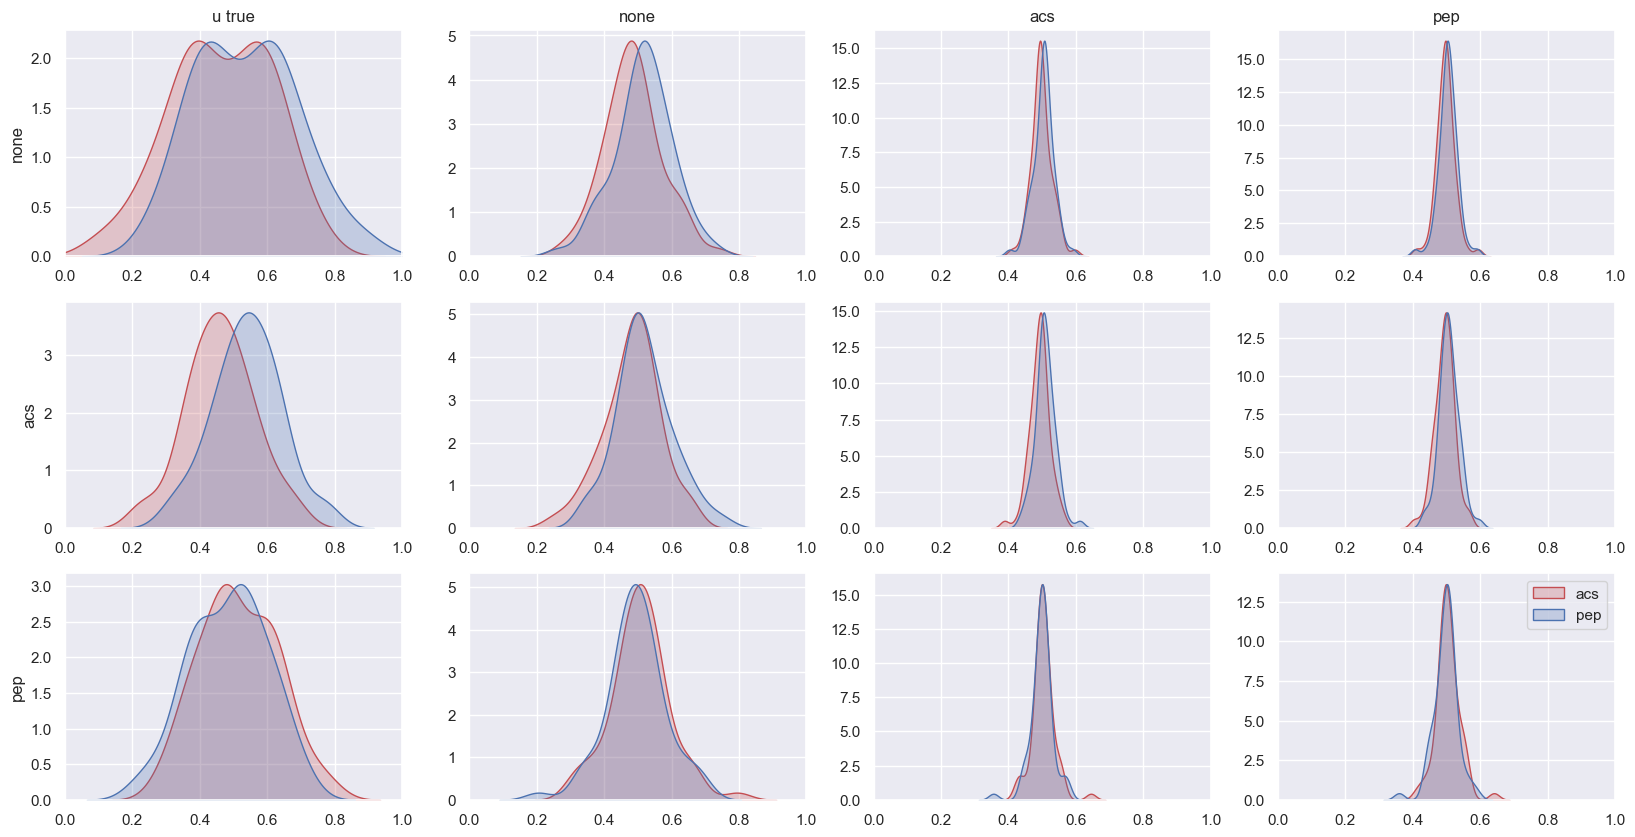

In [33]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [20, 10]
labels = models[:]
labels.insert(0, 'none')

fig = plt.figure()
iter = 0

for pivot_DGP in range(-1,2):
    
    iter = iter + 1
    plt.subplot(3, 4, iter)
    
    u_true = res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: -1'][4]
    
    CAR_df = pd.DataFrame(u_true[0,:,:], columns = models)
    #CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

    plt.subplot(3, 4, iter)
    sns.set(style="darkgrid")
    tt = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
    tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
    #tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
    if pivot_DGP == -1:
        plt.title('u true')
    plt.ylabel(labels[pivot_DGP + 1])
    plt.xlabel('')
    plt.xlim(0,1)
    
    for pivot_fit in range(-1,2):
        iter = iter + 1
        key = 'pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)    
        #print(key)
        CAR_samples = res_dict[key][0]
        CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2).numpy()
        if pivot_fit > -1:
            CAR_ensemble_weights = tf.constant(np.insert(CAR_ensemble_weights, pivot_fit, 0., axis = 1))
        #CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

        # get exponentiated values and sum across models
        exp_phi = tf.math.exp(CAR_ensemble_weights)

        exp_phi_rows = tf.reduce_sum(exp_phi, 1)

        # get model weights and calculate mean estimate
        u = exp_phi/exp_phi_rows[...,None]

        CAR_df = pd.DataFrame(u, columns = models)
        #CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

        plt.subplot(3, 4, iter)
        sns.set(style="darkgrid")
        tt = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
        tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
        #tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
        #plt.legend()
        plt.xlabel('')
        plt.ylabel('')
        if pivot_DGP == -1:
            plt.title(labels[pivot_fit + 1])
        plt.xlim(0,1)
        
plt.legend()
plt.show()

In [ ]:
## Get the average y predictions from the MCMC samples

pivot = 0
predictions = np.empty(shape=(CAR_samples[0].shape[0], CAR_samples[0].shape[2]), dtype='object')
for i in range(CAR_samples[0].shape[2]):
    phi_vals = CAR_samples[0][:,:,i].numpy()
    phi_vals = np.insert(phi_vals, pivot, 0., axis = 1)
    
    # get exponentiated values and sum across models
    exp_phi = tf.math.exp(tf.constant(phi_vals))

    exp_phi_rows = tf.reduce_sum(exp_phi, 1)

    # get model weights and calculate mean estimate
    u = exp_phi/exp_phi_rows[...,None]

    tmp = data_sub[models].values*u
    predictions[:,i] = tf.reduce_sum(tmp, axis = 1)
    
y_pred = np.mean(predictions, axis = 1)

In [ ]:
## Get the average ensemble weights from the CAR samples

CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2).numpy()
CAR_ensemble_weights = tf.constant(np.insert(CAR_ensemble_weights, pivot, 0., axis = 1))
#CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)

exp_phi_rows = tf.reduce_sum(exp_phi, 1)
    
# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]

In [ ]:
# Create the weights dict for plotting the outcomes

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
from scipy.stats import pearsonr
pearsonr(data_sub['census'],data_sub['pep'])[0], pearsonr(data_sub['census'],data_sub['acs'])[0], pearsonr(data_sub['census'],data_sub['worldpop'])[0]

In [ ]:
import seaborn as sns

CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2).numpy()
CAR_ensemble_weights = np.insert(CAR_ensemble_weights, pivot, 0., axis = 1)

CAR_df = pd.DataFrame(CAR_ensemble_weights, columns = ["acs","pep","worldpop"])
#CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

sns.set(style="darkgrid")
fig = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
fig = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
fig = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
plt.legend()
plt.xlabel('phi values')
plt.show()

In [ ]:
import seaborn as sns

CAR_df = pd.DataFrame(u, columns = ["acs","pep","worldpop"])
#CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

sns.set(style="darkgrid")
fig = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
fig = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
fig = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
plt.legend()
plt.xlabel('u values')
plt.show()

In [ ]:
# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)
exp_phi_rows = tf.reduce_sum(exp_phi, 1)

# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]

In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [ ]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [ ]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
phi_true.shape

In [ ]:
x = np.ndarray.flatten(full_phi.iloc[:,1:].to_numpy())
y = np.ndarray.flatten(CAR_ensemble_weights.numpy())
plt.scatter(x, y)

plt.xlabel("true phi")
plt.ylabel("mean MCMC phi")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]

In [ ]:
x = np.ndarray.flatten(full_u.iloc[:,1:].values)
y = np.ndarray.flatten(u.numpy())
plt.scatter(x, y)
plt.xlabel("true u")
plt.ylabel("mean MCMC u")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]

In [ ]:
x = data_sub['census']
y = y_pred
#y = y_pred.numpy()
plt.scatter(x, y)
plt.xlabel("true census values")
plt.ylabel("predicted census values")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y.astype('float64'), 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]